# aixtra Experimentation Notebook

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import itertools
import re
import uuid
import json

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [35]:
class UUIDEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, uuid.UUID):
      # if the obj is uuid, we simply return the value of uuid
      return str(obj)
    return json.JSONEncoder.default(self, obj)

## Load and show images

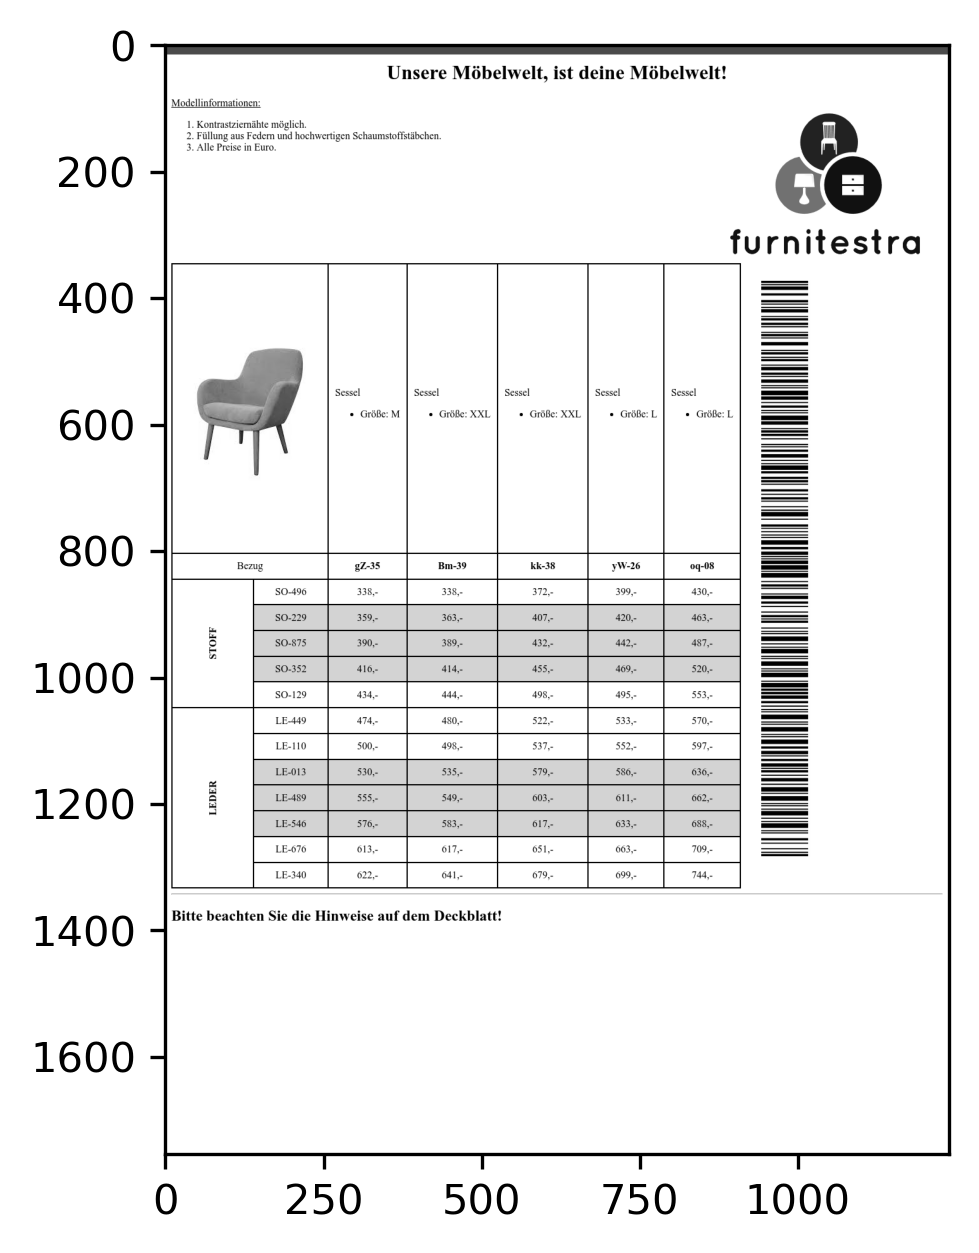

1240 1754


In [36]:
def show_image(opencv_img):
  rgb_im = cv2.cvtColor(opencv_img, cv2.COLOR_BGR2RGB)
  plt.imshow(rgb_im)
  plt.show()

image = cv2.imread("./images/easy.png", 0)
show_image(image)

height, width = image.shape
print(width, height)

## Image processing

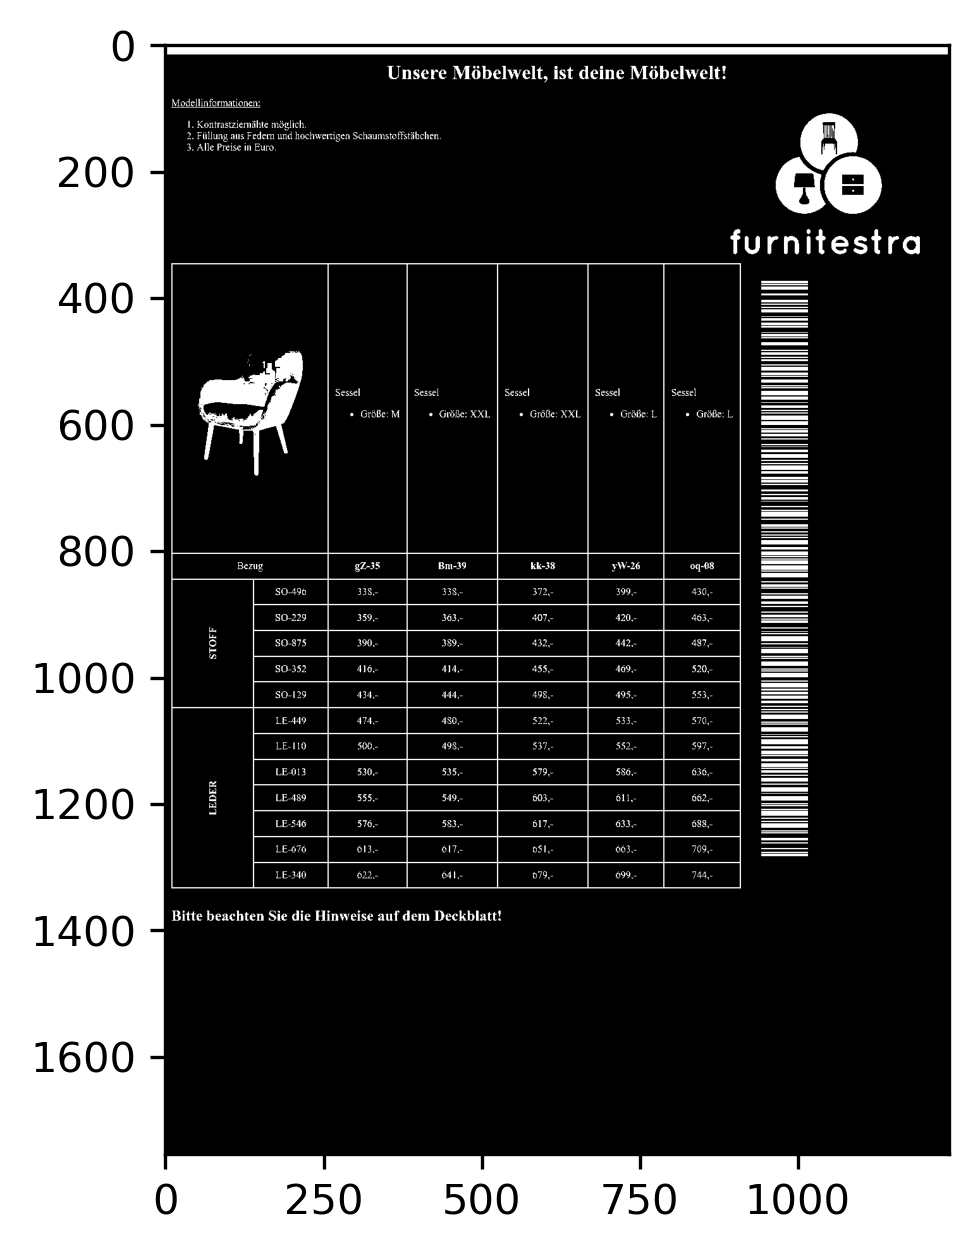

In [37]:
# Make image grayscale
convert_bin,grey_scale = cv2.threshold(image,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
grey_scale = 255-grey_scale

plt.imshow(grey_scale,cmap='gray')
plt.show()

12


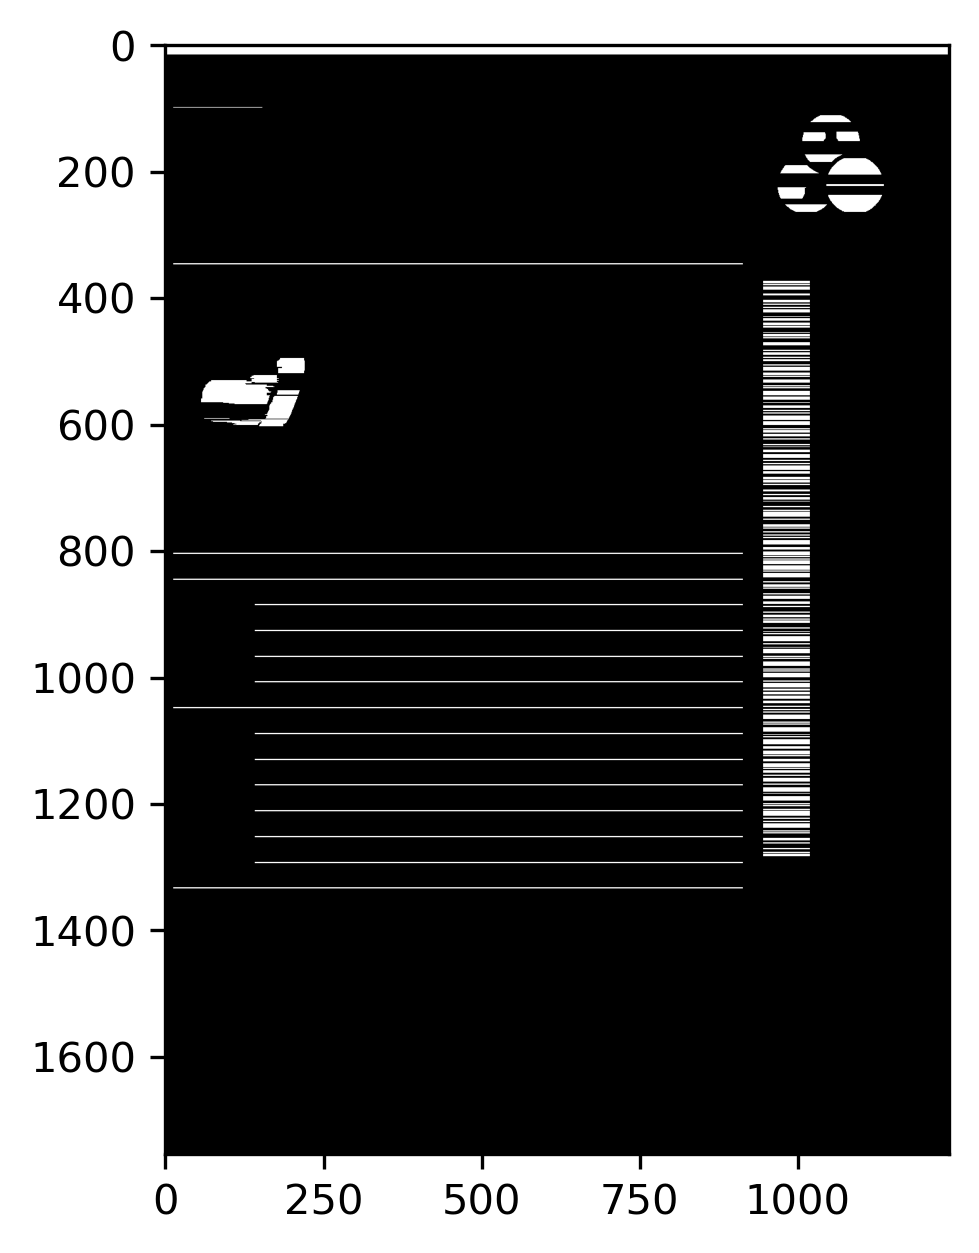

In [38]:
# Detect horizontal

length = np.array(image).shape[1]//100
print(length)

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (length, 1))
horizontal_detect = cv2.erode(grey_scale, horizontal_kernel, iterations=3)
hor_lines = cv2.dilate(horizontal_detect, horizontal_kernel, iterations=3)
plotting = plt.imshow(hor_lines,cmap='gray')
plt.show()

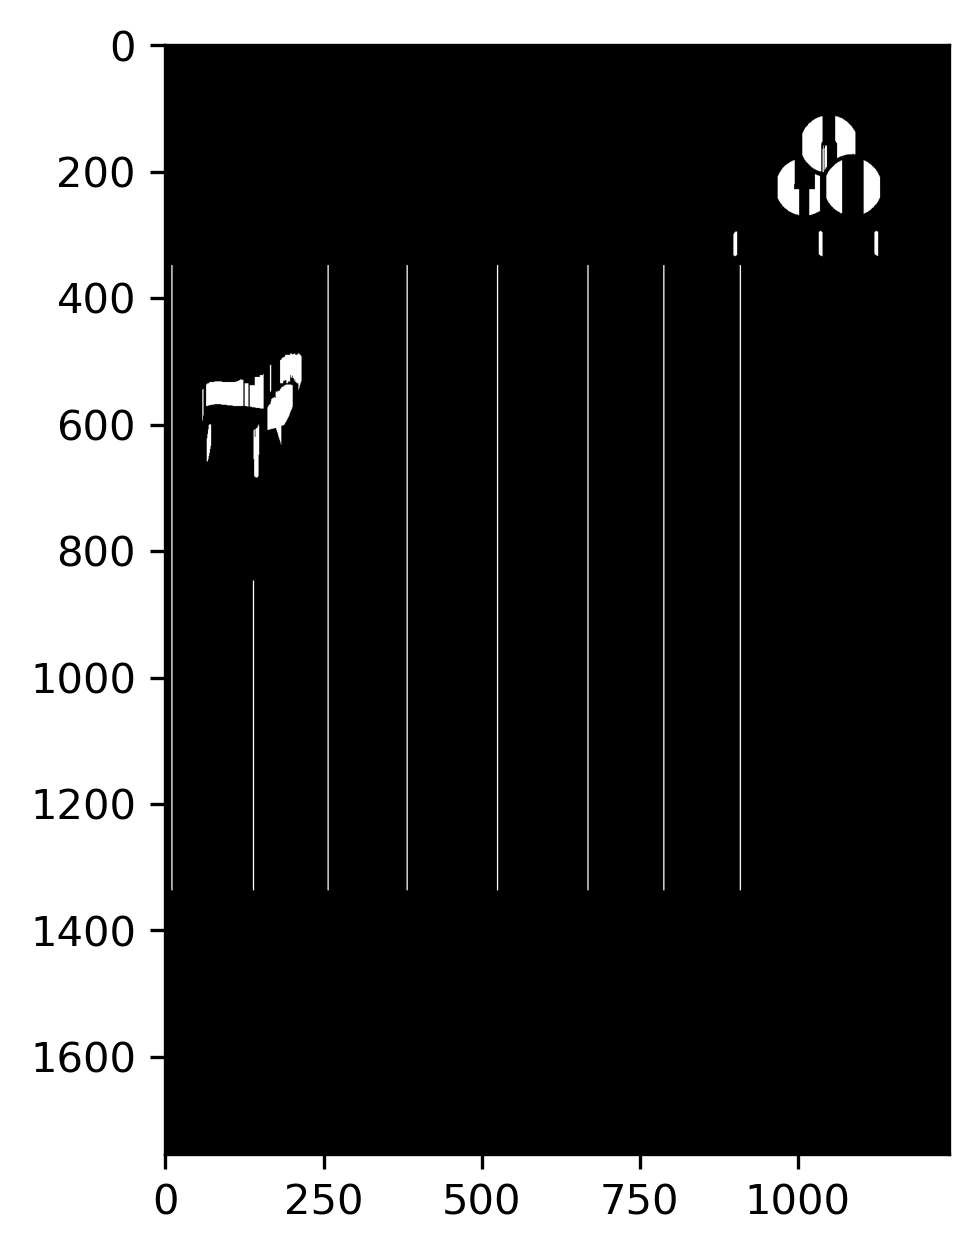

In [39]:
# Detect vertical

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, length))
vertical_detect = cv2.erode(grey_scale, vertical_kernel, iterations=3)
ver_lines = cv2.dilate(vertical_detect, vertical_kernel, iterations=3)
plt.imshow(ver_lines,cmap='gray')
plt.show()

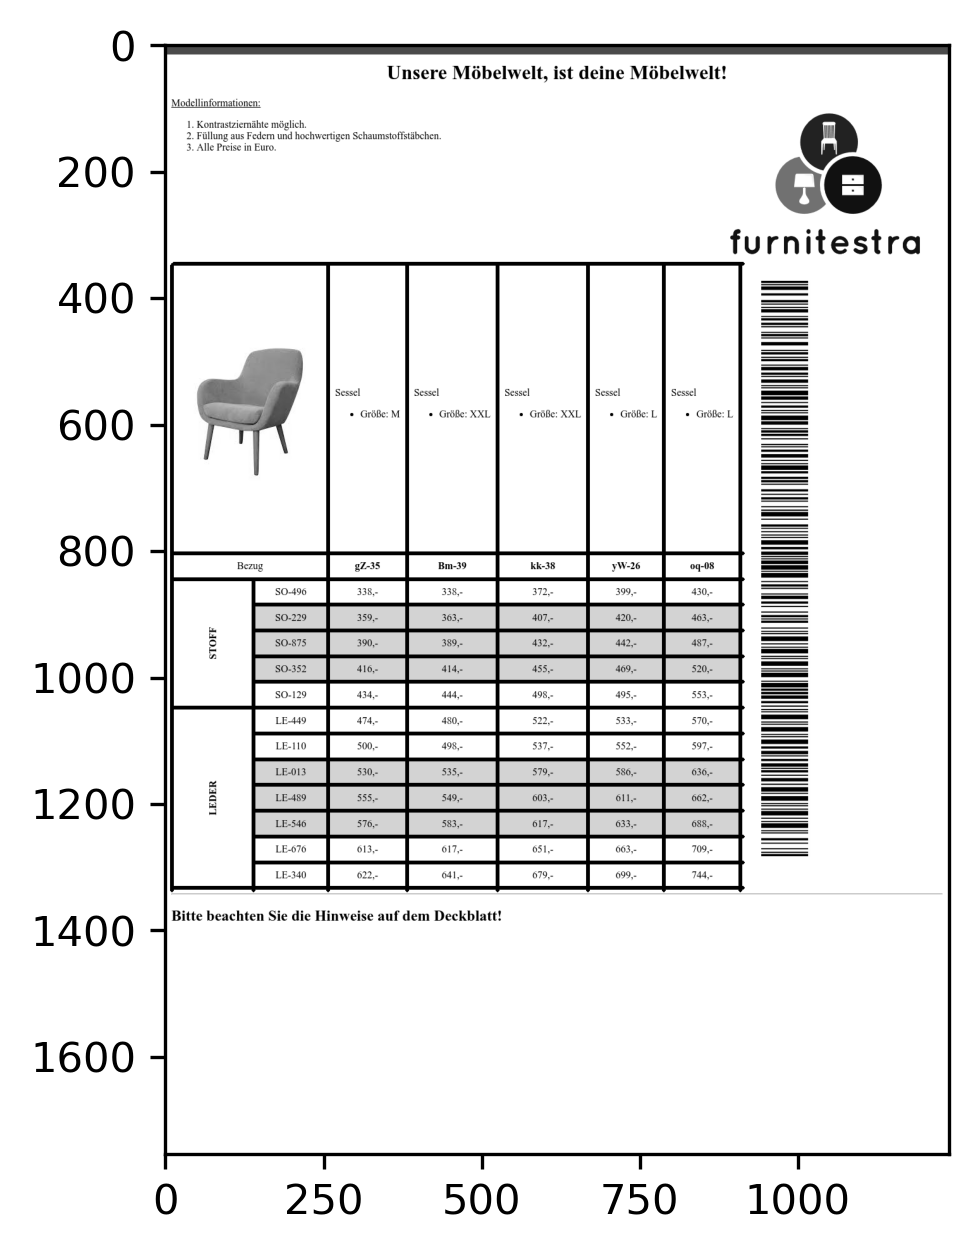

In [40]:
def find_long_horizontal_lines(hor_lines):
  # Find long horizontal lines that. They belong to our table.
  height, width = hor_lines.shape

  # Each entry is [row_start, row_end, col_start, col_end]
  hor_table_lines = []

  # We look for one long (min. half image width) line per row.
  for row in range(height):
    line_start = None

    for column in range(width):
      if hor_lines[row,column]:
        if line_start is None:
          line_start = column    
      else:
        if line_start and (column - line_start) > width / 5:
          hor_table_lines.append([row, row, line_start, column])

        line_start = None

  # Merge adjacent lines
  i = 0
  while i < len(hor_table_lines) - 1:
    curr = hor_table_lines[i]
    next = hor_table_lines[i + 1]

    if curr[0] + 1 == next[0] and curr[2:] == next[2:]:
      curr[1] += 1
      hor_table_lines.remove(next)

    i += 1

  return hor_table_lines


hor_table_lines = find_long_horizontal_lines(hor_lines)
ver_table_lines = [[*line[2:], *line[:2]] for line in find_long_horizontal_lines(ver_lines.T)]

# Output the found lines
temp_img = image.copy()
for line in [*hor_table_lines, *ver_table_lines]:
  cv2.rectangle(temp_img, (line[2], line[0]), (line[3], line[1]), (0, 255, 0), 3)
show_image(temp_img)

In [41]:
def get_row(index):
  """
  Return the start_y and end_y of the row with this index
  """
  return hor_table_lines[index][1] + 1, hor_table_lines[index + 1][0]

def get_column(index):
  """
  Return the start_x and end_x of the column with this index
  """
  return ver_table_lines[index][3] + 1, ver_table_lines[index + 1][2]

column_count = len(ver_table_lines) - 1
row_count = len(hor_table_lines) - 1

In [59]:
def parse_cell(row_start, column_start, row_end=None, column_end=None, rotate=False):
  start_y, end_y = get_row(row_start)
  start_x, end_x = get_column(column_start)

  if row_end:
    end_y = get_row(row_end)[1]

  if column_end:
    end_x = get_column(column_end)[1]

  cell = image[start_y:end_y, start_x:end_x]

  if rotate:
    cell = cv2.rotate(cell, cv2.ROTATE_90_CLOCKWISE)

  text = pytesseract.image_to_string(cell, lang="deu").strip()

  return text

In [60]:
def get_simple_features():
  start_y, end_y = get_row(0)

  simple_features = {}
  simple_feature_values = []

  for col_index in range(2, column_count):
    text = parse_cell(0, col_index)
    print(text)
    features = re.findall("\s*(\S+): (\S+)\s*", text)

    values = {}

    for name, value in features:
      if name not in simple_features:
        simple_features[name] = set([value])
      else:
        simple_features[name].add(value)

      values[name] = value

    simple_feature_values.append(values)

  simple_features = [
    {'name': name, 'values': list(value)} for name, value in simple_features.items()
  ]
    
  return simple_features, simple_feature_values

simple_features, simple_feature_values = get_simple_features()
print(simple_features) 
print(simple_feature_values) 

Sessel

« Größe: M
Sessel

öße: XXL
Sessel

« Größe: XXL
Sessel

« Größe: L
Sessel

« Größe: L
[{'name': 'Größe', 'values': ['XXL', 'L', 'M']}, {'name': 'öße', 'values': ['XXL']}]
[{'Größe': 'M'}, {'öße': 'XXL'}, {'Größe': 'XXL'}, {'Größe': 'L'}, {'Größe': 'L'}]


In [44]:
# Check if a cell has a row delimiter at the top
def check_row_delimiter(row, column):
  start_x, end_x = get_column(column)

  return hor_table_lines[row][2] < end_x

In [61]:
# Parse the option range feature

def get_option_range():
  name = parse_cell(1, 0, 1, 1)
  
  # Find option range delimiters
  option_range_delimiter_indices = []
  for row_index in range(2, row_count):
    if check_row_delimiter(row_index, 0):
      option_range_delimiter_indices.append(row_index)

  option_range_delimiter_indices.append(row_count)

  # Parse option range names
  option_ranges = []

  for start, end in itertools.pairwise(option_range_delimiter_indices):
    option_ranges.append({
      'name': parse_cell(start, 0, row_end=end - 1, rotate=True),
      'values': [parse_cell(row, 1) for row in range(start, end)]
    })

  return name, option_ranges

option_range_feature, option_ranges = get_option_range()
print(option_range_feature)
print(option_ranges)

Bezug
[{'name': 'STOFF', 'values': ['SO-496', 'SO-229', 'SO-875', 'SO-352', 'SO-129']}, {'name': 'LEDER', 'values': ['LE-449', 'LE-110', 'LE-013', 'LE-489', 'LE-546', 'LE-676', 'LE-340']}]


In [63]:
# Parse features in the format they want
features = []

# Put all the simple features in
for feature in simple_features:
  id = uuid.uuid4()
  name = feature['name']

  features.append({
    'id': id,
    'nameInFormula': name,
    'optionRanges': [
      {
        'id': uuid.uuid4(),
        'name': name,
        'options': [
          {
            'id': uuid.uuid4(),
            'name': value
          }
          for value in feature['values']
        ]
      }
    ]
  })

# Put the one complex feature in
features.append({
  'id': uuid.uuid4(),
  'nameInFormula': option_range_feature,
  'optionRanges': [
    {
      'id': uuid.uuid4(),
      'name': option_range['name'],
      'options': [{
        'id': uuid.uuid4(),
        'name': value
      } for value in option_range['values']]
    }
    for option_range in option_ranges
  ]
})

print(json.dumps(features, indent=4, cls=UUIDEncoder))

[
    {
        "id": "37c591f5-584e-4f91-9d9f-28a255786ec9",
        "nameInFormula": "Gr\u00f6\u00dfe",
        "optionRanges": [
            {
                "id": "75b28521-be74-48bf-b4d7-935000bc0fb0",
                "name": "Gr\u00f6\u00dfe",
                "options": [
                    {
                        "id": "9273d900-9eb2-46e4-93f4-55f28fb67766",
                        "name": "XXL"
                    },
                    {
                        "id": "c49aad76-0ce7-40b0-9ad3-cd51413e03df",
                        "name": "L"
                    },
                    {
                        "id": "18ac539d-74e4-433b-b6fd-05cff0d5182c",
                        "name": "M"
                    }
                ]
            }
        ]
    },
    {
        "id": "590937cb-5f7b-4043-b673-a9c905d68a79",
        "nameInFormula": "\u00f6\u00dfe",
        "optionRanges": [
            {
                "id": "e108ef9d-2d7d-4b00-9dd4-a16d555d8eaa",
             

In [64]:
prices = []

# Calculate the prices. Go through all rows/columns.
for col in range(2, column_count):
  # Values for simple features
  simple_vals = simple_feature_values[col - 2]

  for row in range(2, row_count):
    option_range_index = 0
    row_offset = 2
    while row - row_offset >= len(option_ranges[option_range_index]['values']):
      row_offset += len(option_ranges[option_range_index]['values'])
      option_range_index += 1
    option_index = row - row_offset    

    price = parse_cell(row, col)
    price = re.findall("^\D*(\d+)\D*$", price)
    if not price:
      continue
    price = int(price[0])

    prices.append({
      'id': uuid.uuid4(),
      'value': {
        'currencyUnit': 'EUR',
        'amountInMinorUnits': price * 100
      },
      'optionSelections': [*[
        {
          'featureId': features[-1]['id'],
          'optionId': features[-1]['optionRanges'][option_range_index]['options'][option_index]['id']
        }
      ], *[
        {
          'featureId': features[feature_index]['id'],
          'optionId': features[feature_index]['optionRanges'][0]['options'][simple_feature['values'].index(simple_vals[simple_feature['name']])]['id']
        }
        for feature_index, simple_feature in enumerate(simple_features)
      ]]
    })    
  
print(json.dumps(prices, indent=4, cls=UUIDEncoder))

KeyError: 'öße'